In [1]:
include("../scripts/ideal_robot.jl")

In [2]:
using Distributions
using Random

In [3]:
mutable struct Camera <: AbstractCamera
    map
    lastdata
    distance_range
    direction_range
    distance_noise_rate
    direction_noise
    distance_bias_rate_std
    direction_bias
end

In [4]:
function Camera(env_map, distance_range=(0.5,6.0), direction_range=(-pi/3, pi/3),
                distance_noise_rate=0.1, direction_noise=pi/90,
                distance_bias_rate_stddev=0.1, direction_bias_stddev=pi/90)
    self = Camera(ntuple(x->nothing, fieldcount(Camera))...)
    self.map = env_map
    self.lastdata = []
    self.distance_range = distance_range
    self.direction_range  = direction_range
    self.distance_noise_rate = distance_noise_rate
    self.direction_noise = direction_noise
    self.distance_bias_rate_std = rand(Normal(0, distance_bias_rate_stddev))
    self.direction_bias = rand(Normal(0, direction_bias_stddev))
    return self
end

Camera

In [5]:
function noise(self::Camera, relpos)
    ell = rand(Normal(relpos[1], abs(relpos[1])*self.distance_noise_rate))
    phi = rand(Normal(relpos[2],  self.direction_noise))
    return [ell, phi]
end

noise (generic function with 1 method)

In [21]:
function bias(self::Camera, relpos)
    return relpos + [relpos[1]*self.distance_bias_rate_std, self.direction_bias]
end

bias (generic function with 2 methods)

In [22]:
function data(self::Camera, cam_pose)
    observed = []
    for lm in self.map.landmarks
        z = observation_function(self, cam_pose, lm.pos)
        if visible(self, z)
            z = bias(self, z)
            z = noise(self, z)
            push!(observed, (z, lm.id))
        end
    end
    self.lastdata = observed
    return observed
end

data (generic function with 2 methods)

In [23]:
mutable struct Robot <: AbstractRobot
    pose
    r
    color
    agent
    poses
    sensor
    noise_pdf
    distance_until_noise
    theta_noise
    bias_rate_nu
    bias_rate_omega
    stuck_pdf
    escape_pdf
    time_until_stuck
    time_until_escape
    is_stuck
    kidnap_pdf
    time_until_kidnap
    kidnap_dist
end

function Robot(pose, agent, sensor, color, noise_per_meter = 5, noise_std=pi/60,
    bias_rate_stds=(0.1,0.1), expected_stuck_time=1e100, expected_escape_time = 1e-100,
    expected_kidnap_time=1e100, kidnap_range_x=(-5.0, 5.0), kidnap_range_y=(-5.0, 5.0))
    rbt = Robot(ntuple(x->nothing, fieldcount(Robot))...)
    rbt.pose = pose
    rbt.r = 0.2
    rbt.agent = agent
    rbt.sensor = sensor
    rbt.poses = [pose]
    rbt.color = color
    rbt.noise_pdf = Exponential(1.0/(1e-100 + noise_per_meter))
    rbt.distance_until_noise = rand(rbt.noise_pdf)
    rbt.theta_noise = Normal(0, noise_std)
    rbt.bias_rate_nu = rand(Normal(1, bias_rate_stds[1]))
    rbt.bias_rate_omega = rand(Normal(1, bias_rate_stds[2]))
    rbt.stuck_pdf = Exponential(expected_stuck_time)
    rbt.escape_pdf = Exponential(expected_escape_time)
    rbt.time_until_stuck = rand(rbt.stuck_pdf)
    rbt.time_until_escape = rand(rbt.escape_pdf)
    rbt.is_stuck = false
    rbt.kidnap_pdf = Exponential(expected_kidnap_time)
    rbt.time_until_kidnap = rand(rbt.kidnap_pdf)
    rx = kidnap_range_x
    ry = kidnap_range_y
    rbt.kidnap_dist = (Uniform(rx[1], rx[2]), Uniform(ry[1], ry[2]), Uniform(0, 2*pi))
    return rbt
end

function noise(self::Robot, pose, nu, omega, time_interval)
    self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
    if self.distance_until_noise <= 0.0
        self.distance_until_noise += rand(self.noise_pdf)
        pose[3] += rand(self.theta_noise)
    end
    return pose
end

function bias(self::Robot, nu, omega)
    return nu*self.bias_rate_nu, omega*self.bias_rate_omega
end

function stuck(self::Robot, nu, omega, time_interval)
    if self.is_stuck
        self.time_until_escape -= time_interval
        if self.time_until_escape <= 0.0
            self.time_until_escape += rand(self.escape_pdf)
            self.is_stuck = false
        end
    else
        self.time_until_stuck -= time_interval
        if self.time_until_stuck <= 0.0
            self.time_until_stuck += rand(self.stuck_pdf)
            self.is_stuck = true
        end
    end
    return nu*(!self.is_stuck), omega*(!self.is_stuck)
end

function kidnap(self::Robot, pose, time_interval)
    self.time_until_kidnap -= time_interval
    if self.time_until_kidnap <= 0.0
        self.time_until_kidnap += rand(self.kidnap_pdf)
        return [rand(self.kidnap_dist[1]), rand(self.kidnap_dist[2]), rand(self.kidnap_dist[3])]
    else
        return pose
    end
end

function one_step(self::Robot, time_interval)
    if isnothing(self.agent)
        return
    end
    obs = nothing
    if !isnothing(self.sensor)
        obs = data(self.sensor, self.pose)
    end
    nu, omega = decision(self.agent, obs)
    nu, omega = bias(self, nu, omega)
    nu, omega = stuck(self, nu, omega, time_interval)
    self.pose = state_transition(self, nu, omega, time_interval)
    self.pose = noise(self, self.pose, nu, omega, time_interval)
    self.pose = kidnap(self, self.pose, time_interval)
end

one_step (generic function with 3 methods)

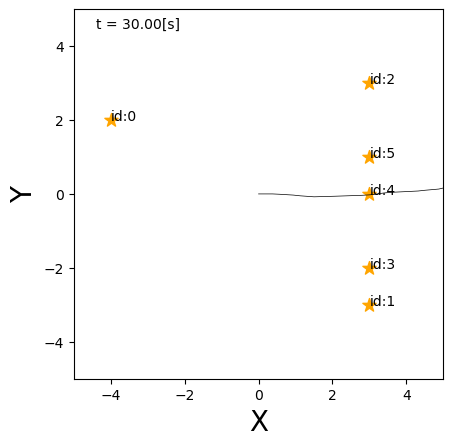

In [25]:
world = World(30, 1.0)
m = Map()
append_landmark(m, Landmark([-4.0,2.0]))
append_landmark(m, Landmark([3.0,-3.0]))
append_landmark(m, Landmark([3.0,3.0]))
append_landmark(m, Landmark([3.0,-2.0]))
append_landmark(m, Landmark([3.0, 0.0]))
append_landmark(m, Landmark([3.0, 1.0]))
append(world, m)

straight = Agent(0.2, 0.0)
r = Robot([0.0, 0.0, 0.0], straight, Camera(m), "black")
append(world, r)
draw(world)

In [26]:
showanim("test.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAXyptZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAIQtliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbUnoMe46cA0yCcv4c9XPLw/TZGcY1pQamfInwrvEjUWYmqj0lYKAw8yQ7YHgF/REjL2SIZbq4BdZHRnZAUqRDmkgIxAPLrVhsCdKTmHRrzBEx6rpSeno0eoUlzcTgmfBt3TKRTHxluRrJsxfHnSf453kTgHfLmICwIwY6DYxCUMqetdclci6MhQI6heLwLBwhsM7Gs14d70o8g90fbsxd9c8/Yuw3lf0vyMfHUrGiwdS7t5fCzF553n13wytrljjW3W4kM+6a0i+07XQ/xydzvvjfqudjZJVHmBHCVh+ZSs0yAx5bRWwdZRZOl6+thUpNjzRRE2+XrrdYhciuNo+6+eWn5iKIb9r2/6wPyD5vCwpGI5ro4xuAmeLADAP1FAnTuuseFRqZt9TSLBhBK5OO3q94y3URHv4UW3RPjWBWcsPM+k+DUuse5l+sjJbNkPChzm1TCKlGwpnast0lvXjU1ONMVKVbNBc1XT8/d9PmEXMgrHZQa9w+biXfc3YFlBXER9+2TGaarhDgZjFB7sLCrPjG8qIg1hC72qnrmrt4+jnv+ImAl1xWy7DiOyVdo0lB361NsnFPHnHvvsIyBM8ciqLRq1JSPuuT8MgBhM838UZTjzcm4Go+0lNk+kgWHHgu2O7R/Xd6zk1fiIMDpVtzu58Hj/TEsJCMHGVRPcKKa4bfswBRoFxeybCPHJl0cWQ9EmMph2QTGRxM1Y0WxZVfw4jviXUiMV8E4KcK45zeU/nq/ObjU3PDcEUKBABpfSUJJS/G5v7RjUW4kw9UXwYPAJm7qlK2yFUUa5U1tdIPrdXJcm0QnN1jsRaoFE04W8G9VamippiEGvcwb10M7wg3QzcciavM2wpjnmNVnKBvrcFwVNONNNqfSkYdFaFNPy/0jFocpcYqPj0kYgYu7u30fYO6YeqWLLF5DJi/XUU2gpuinbuO79q0GkkAbalzqhMynQIUe87BFzygjjeRcv4M0+IyqorGsKaicGwq3t9gG5Nza3GBLvTrMWzTNcO+ooqcK/SjwtQOuDpxsoWwhL4K3r4Z3sEO5s327UEjzLC8484+B6NlhlUDyFsjIcZUQ495Ipp7dgSPYz9XAR02tIWZpv8nQWSISFR1HkvJAPhCotrroZLit2iGJF+JtiX8re01ft799UyndHsCGU8GBwBx7N0VrY3/J20ilOGAuJ3dwmbO1unBkS4imqoaBb3SAi2N05uMBK1kwfMJvp5NLaLHx9g5WqV4J8wSet5Yx/wSQ+QkjgTL+vdIZUpeW99+5LsZObee5gflj4FVaX/bGOSpnYKVSutfI4E40UPpUAxLk7kdp6clKTrUB1AIIoDqmWWgSfa8u3EpAm6ZISfNBdWUP3Jviaxo1Df8banfj083nWuExPsbSPutybXbBYiSZepgZMvbObtY/DAQLFbLptPjfqaznvZUkMHM+1jW5HLsHDMJ4H5cG08Bq3uXOuCqEk4dRp6JLyzKh51IIWH5ImB2TNqT8JIbGQAipmQ1vIIJfUcurZ2S8WAcPmI8jmcARwpIHHJxfIsHFbSjR8Nx7U9kBmNwppk2yR2ChYR8X5/IpykO6nSemGWGxP8mo0dgMSCDNnnRQU1hM+LmFhjxzeiSK+nPa4PMN+ieGqYn5x2jdSDk56a6gieQEF2R1VId9j7rkdbMUgiTdiaMo730QE7A7me0g006IdQ4YRTbxFfsq3/nAsIppciGZ+y/ofMoqOXcSLZgBNsmCB91I6Oigv5JRg6zEgmD5ps3E5LKHqkPc6nuafVLY/OReR4+9IvO0MOOsRcqi5SMv2KgFrb4KNj6OROjRD0t9eQFupTK3DoZtEe9BPSvtEx/5nyUmSu/Zo4eQQfdAI8RgSkAT4L394iC8jyu3dUhecwRB4h46NafcJMooDhAlpcMtvvTIIBfzJZMztksWla7SfYMiTFYKzLVV1Cx+NhQcrHOQjfjaMLk8f5NGg0L5Pj9fL6catfhxEc1thwURDmP4OJLISuHySbDj9ZFHTN/6qRcfdKLPFGqJUBfY9QfIV3b/+wBMhk3IZ2M6zTvxnwse9Nz+qZMlTHUV6z0f5JMMoF8q6QuvJZxKDSJrxygcmo556mSpIBMhInlAeY7Ul0xcIvZS0AJZMCT/nlnf9meB02ldG0SOAyOWbONPW6S1gF94cPsG/kP1HEpjjUnKfHaDr2SeUuYk5ryxnmUeZYdLeulwve5du0gRnvu/NILkSj1QdB3F1XryCNKRFrX0ggXi2RyzV4PuJJId4/GL/L9XgnBU5rqclC6CJ2BWvecGxMfihwvJ/pJRYVFyqmFcC3znN48/Txxn1ERqo0ebziZ584ydwUhDIlmG3lXSu4evPFJBAe8KQ2PT5+mA8jN5Bk46bI6BBx46RmovChG3lT4+aeFZhjE5aV3cIsp2F29NjKxX+0/qxmoz1E6nfQ0IEmrOPbnHXCbA8ws+TQhKXbmrnf9Xlv2MNLSXjSYD1QKl9VewRQIFJv/M2pmis5d7r75l6hx2IComBl3DrxVmVVot8MAwrJcRvItXmIoUX0Xl2noXf5VA2au1sCwslwlxzJKoumBtcnZ9ndEC